## 1. Introduction and Description

In this notebook we will perform an Exploratory Data Analysis, train various model architectures and perform some hyperparameter tuning for the Kaggle Histopathologic Cancer Detection competition (https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). For the various model architectures we will also create Kaggle competition submission files and submit them to see what the scores are on the private test set.

The Kaggle competition is summarized as follows:

*In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).*

The challenge is to build a binary classifier that can make the correct predictions for the images. All images are of the TIF image type and in color. Image size is 96 * 96 pixels. The total dataset size is little over 200K of training images and about 57K of test images. A further look at the dataset will bet done in the EDA section The Kaggle version of the dataset is cleaned and does not contain duplicates...so we don't have to handle that possible problem.

The evaluation of the Kaggle competition submission is based on the area under the ROC curve between the predicted probability and the observed target. In this notebook we will also use the AUC metric when training, validating and hyperparameter tuning all the different models.

## 2. Exploratory Data Analysis

In this section we will perform some basic Exploratory Data Analysis about the data and images.

As a first step we will import the required Python modules, set some some basic constants and directory variables and import the CSV file that contains the training dataset labels.

Note!! For all different model architectures and hyperparameter tuning experiments we keep the number of epochs at a fixed amount of 8. While with certain hyperparameters or models more epochs might lead to a better result I have to make a trade off with the GPU time that I have available. 

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Constants
EPOCHS = 8
BASE_DIR = 'C:/DTSA5311/histopathologic-cancer-detection/'
TRAIN_DIR = f'{BASE_DIR}train/'
TEST_DIR = f'{BASE_DIR}test/'

# Import Train Data
data_df = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
data_df['filename'] = data_df['id'] + '.tif'
data_df.label = data_df.label.astype("string")
data_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


We can see the first 5 rows of the train_labels.csv file. For every file there is an 'id' and a binary label with a value of 0 or 1.

I've added an extra column 'filename'. It contains the 'id' of the file with the file extension '.tif' added. When training and validating all models we will use the 'filename' column as input for the ImageDataGenerator class.

Lets look at the size of the data that we have to deal with when training the models.

In [2]:
data_df.shape

(220025, 3)

We have a total of 220025 images available for training and validation.

Lets take a look at the value count of the labels.

In [3]:
data_df.label.value_counts()

0    130908
1     89117
Name: label, dtype: Int64

We have around 130K of 0 labels and around 90K of 1 labels. The dataset is slightly unbalanced considering the label distribution. Allthough this likely won't affect the training of the models much lets make the dataset balanced. I will do this by downsampling the 0 labels to the same amount as the 1 labels.

New balanced data set shape: (178234, 3)


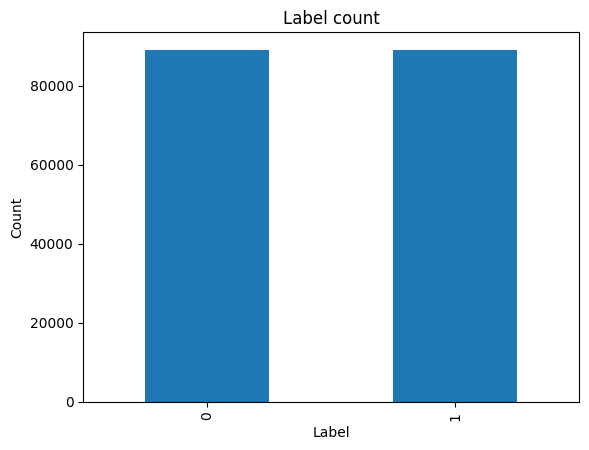

In [4]:
# Downsample data to balance labels
label1_df = data_df[data_df.label == '1']
label0_df = data_df[data_df.label == '0'].sample(n = 89117, random_state = 42)
data_df = pd.concat([label0_df, label1_df])
print(f'New balanced data set shape: {data_df.shape}')

# Plot Label count
data_df.label.value_counts().plot(kind = 'bar')
plt.title('Label count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

We can see that we now have a balanced data set with equal amount of 0 and 1 labels. With still around 178K of images available for training and validation that should be more than enough to create some good performing models.

Next lets take a look at some of the sample images for both the positive labels and the negative labels

Text(0.5, 1.0, 'Positive Labels - Cancer')

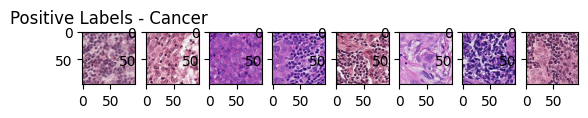

In [5]:
# Plot Positive Label Samples
positive_samples = data_df[data_df.label == '1'].sample(n = 8, random_state = 42)
f, ax = plt.subplots(1, 8)
for i, image_name in enumerate(positive_samples.filename.values):
    ax[i].imshow(imread(f'{TRAIN_DIR}{image_name}'))
ax[0].set_title('Positive Labels - Cancer')

Text(0.5, 1.0, 'Negative Labels - No Cancer')

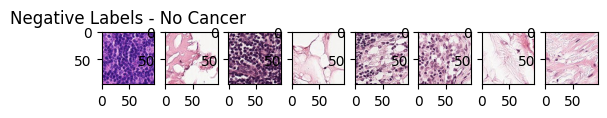

In [6]:
# Plot Negative Label Samples
negative_samples = data_df[data_df.label == '0'].sample(n = 8, random_state = 42)
f, ax = plt.subplots(1, 8)
for i, image_name in enumerate(negative_samples.filename.values):
    ax[i].imshow(imread(f'{TRAIN_DIR}{image_name}'))
ax[0].set_title('Negative Labels - No Cancer')

We've got some interresting medical tissue images. Some images in the positive and negative samples look a lot alike. 

I myself don't have the medical knowledge to see the exact difference...so let's see how good are models will be in determining the difference.

As a last step lets take a look at the image histograms for the positive and negative samples

Text(0, 0.5, 'Pixel count')

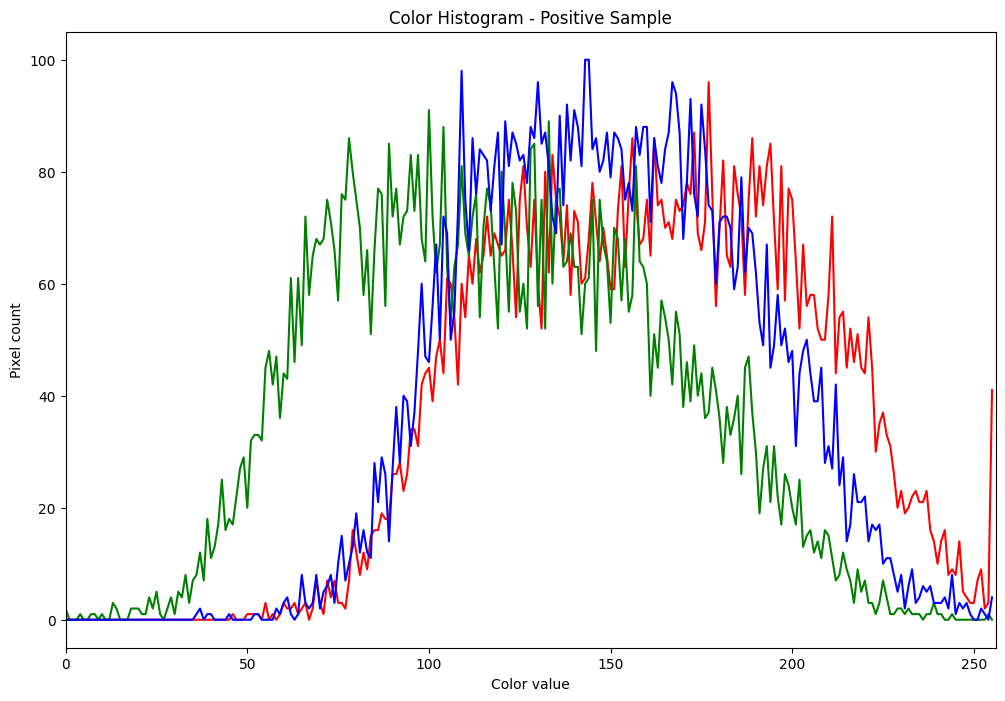

In [7]:
# !! Histogram Plot code source reference: https://datacarpentry.org/image-processing/05-creating-histograms/

# Histogram - Positive Image
pos_image = imread(f'{TRAIN_DIR}{positive_samples.filename.values[0]}')

# Colors
colors = ("red", "green", "blue")

# Plot Histogram for each color channel
plt.figure(figsize = (12, 8)) 
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(pos_image[:, :, channel_id], bins = 256, range = (0, 256))
    plt.plot(bin_edges[0:-1], histogram, color = color)
plt.title("Color Histogram - Positive Sample")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

Text(0, 0.5, 'Pixel count')

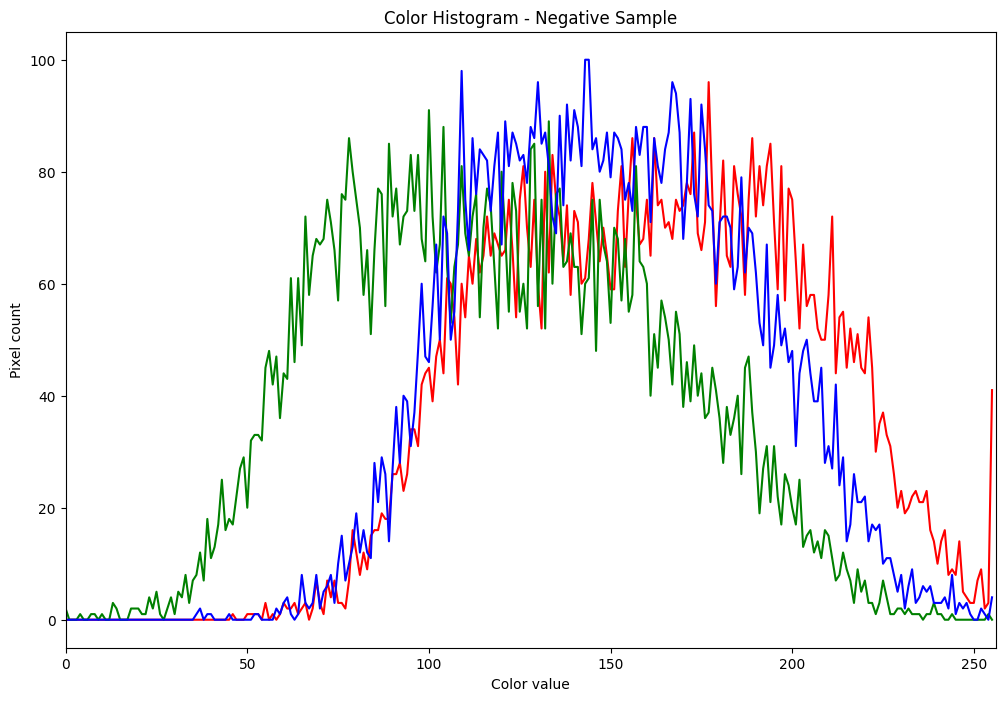

In [8]:
# !! Histogram Plot code source reference: https://datacarpentry.org/image-processing/05-creating-histograms/

# Histogram - Positive Image
neg_image = imread(f'{TRAIN_DIR}{negative_samples.filename.values[0]}')

# Plot Histogram for each color channel
plt.figure(figsize = (12, 8)) 
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(pos_image[:, :, channel_id], bins = 256, range = (0, 256))
    plt.plot(bin_edges[0:-1], histogram, color = color)
plt.title("Color Histogram - Negative Sample")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

## 3. Model Architectures and Training

In total I will test 6 different computer vision model architectures. The first 2 are custom CNN simple model architectures that will be trained from scratch. Next we will start with a standard ResNet50 model with no pretrained weights loaded. This model will also be trained from scratch. The fourth model is the same ResNet50 model as was previously trained but now with the 'Imagenet' pretrained weights loaded. In this case we will be performing transfer learning to see what the effects of that will be. The last 2 model architectures are also ResNets that will be trained with the 'Imagenet' pretrained weights loaded but with different amount of layers. The 5th model contains 101 layers and the 6th model 152 layers.

The 6 models were chosen to provide a broad overview of what the performance differences are when we choose to design our own CNN model or to chose a default model with different amount of layers and weights. I expect the custom CNN models to already provide a decent performance and they should be quick to train. The ResNet architectures should provide higher performance especially when we use the pretrained Imagenet weights. In this case the models uses a set of weights that is already pretrained on over 1 million images. Increasing the layers from 50 to 152 should even further improve the performance that is achieved. In a later section I will further analyse those results. The plot of the model trainings will also be plot and shown there.

All models will be trained with an Adam optimzer chosen with a lower learning rate. The batch size for all models will be set to 64.

All models will be trained with the image size as-is. There is no need to upscale or downscale from the default 96 * 96 pixels.

For the training data only simple augmentation such as horizontal and vertical flip is used. All training images will be shuffled each epoch.

For the validation data no augmentation is used and also the images will not be shuffled.

For all models the model files will be saved with the ModelCheckpoint utility from tensorflow.keras. This utility will monitor each model training for the best performing Validation AUC. Later on in the notebook the saved model files will be used to create 6 submission files, 1 for each model. These submission files will be submitted to the Kaggle Competition.

### 3.1 Setup and Preparation

After we have balanced the training data earlier we had about 178K of images remaining. For all further training and hyperparameter tuning we will use 80% as training data and the remaining 20% as validation data. We set the random_state to a fixed value so that the results are always the same.

In [9]:
# Train Test Split
train_df, val_df = train_test_split(data_df, test_size = 0.2, stratify = data_df.label, random_state = 42)
print(train_df.shape)
print(val_df.shape)

(142587, 3)
(35647, 3)


Next we setup a placeholder list to contain the training results, define a function for the model checkpointing and we prepare a 'train_data' and 'val_data' datasets that will be used by all the models for training and validation. Note that the ImageDataGenerator class is used to create an easy setup.

In [10]:
# Placeholder
history_val_auc_list = []

# Model Checkpointing
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(model_name,
                                              monitor = 'val_auc',
                                              verbose = 0,
                                              save_best_only = True,
                                              save_weights_only = False,
                                              mode = 'max',
                                              save_freq='epoch')

# Create ImageDataGenerators 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.,
                                                                horizontal_flip=True,
                                                                vertical_flip = True)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

# Applying our generators to our data
train_data = train_datagen.flow_from_dataframe(dataframe = train_df,
                                               directory = TRAIN_DIR, 
                                               x_col = 'filename', 
                                               y_col = 'label',
                                               target_size = (96, 96),
                                               batch_size = 64,
                                               class_mode = 'binary',
                                               shuffle = True)

val_data = valid_datagen.flow_from_dataframe(dataframe = val_df, 
                                             directory = TRAIN_DIR, 
                                             x_col = 'filename', 
                                             y_col = 'label',
                                             target_size = (96, 96), 
                                             batch_size = 64,
                                             class_mode = 'binary',
                                             shuffle = False)

Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


### 3.2 Custom CNN Model 1

This is the first custom CNN model. It contains 2 times 2 Convolution layers followed by an AveragePooling layer. The final head layers flatten the AveragePooling layer, added a Dropout layer for regularization and a final Dense layer.

In [11]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 1
img = tf.keras.layers.Input(shape = (96, 96, 3))
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(img)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dropout(0.25)(X)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model1 = tf.keras.Model(inputs = img, outputs = preds)

# Compile Model
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model1.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_1.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9551196694374084


### 3.3 Custom CNN Model 2

The second custom CNN model is basically the same as the first custom CNN model however it contains one more set of 2 Convolutional layers followed by an AveragePooling layer. In theory this model should be able to capture more details and provide a higher performance.

In [12]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 2
img = tf.keras.layers.Input(shape = (96, 96, 3))
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(img)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dropout(0.25)(X)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model2 = tf.keras.Model(inputs = img, outputs = preds)

# Compile Model
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model2.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_2.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9694810509681702


### 3.4 ResNet50 Model with no pretrained model weights

As a 3rd model we will use a ResNet50 model but we will not load the available pretrained 'Imagenet' weights. The model will be trained from scratch. This experiment will give us some insights into the improvements that an advanced model architecture can provide us compared to the earlier 2 custom CNN models.

In [13]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 3
resnet_model3 = tf.keras.applications.resnet50.ResNet50(weights = None, 
                                                        include_top = False, 
                                                        input_shape = (96, 96, 3), 
                                                        pooling = 'avg',
                                                        classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model3.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model3 = tf.keras.Model(inputs = resnet_model3.input, outputs = preds)

# Compile Model
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model3.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_3.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9717132449150085


### 3.5 ResNet50 Model with 'Imagenet' pretrained model weights (Transfer Learning)

The 4th model is again a ResNet50 model. This time however with the 'Imagenet' pretrained weights file loaded. The model will be trained based on the principle of 'Transfer Learning'. It is expected that this will give a boost to the performance achieved. We can compare the results to the earlier 2 custom CNN modules and the previously trained ResNet50 model with no pretrained weights loaded.

In [14]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 4
resnet_model4 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                        include_top = False, 
                                                        input_shape = (96, 96, 3), 
                                                        pooling = 'avg',
                                                        classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model4.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model4 = tf.keras.Model(inputs = resnet_model4.input, outputs = preds)

# Compile Model
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model4.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_4.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9917413592338562


### 3.6 ResNet101 Model with 'Imagenet' pretrained model weights (Transfer Learning)

The 5th model is a ResNet101. It is a larger version of the ResNet50 model and contains 101 layers. This model will be trained with 'Imagenet' pretrained weights file loaded.

In [15]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 5
resnet_model5 = tf.keras.applications.resnet.ResNet101(weights = 'imagenet', 
                                                     include_top = False, 
                                                     input_shape = (96, 96, 3), 
                                                     pooling = 'avg',
                                                     classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model5.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model5 = tf.keras.Model(inputs = resnet_model5.input, outputs = preds)

# Compile Model
model5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model5.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_5.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9928428530693054


### 3.7 ResNet152V2 with 'Imagenet' pretrained model weights (Transfer Learning)

The 6th and last model to be trained is a ResNet152V2. This model contains 152 layers in total and is based on an updated version of ResNet hence the V2 versioning. 

This model will again be trained with 'Imagenet' pretrained weights file loaded. In theory this model should provide us the highest performance that can be achieved since it is the largest model that we use.

In [16]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 6
resnet_model6 = tf.keras.applications.ResNet152V2(weights = 'imagenet', 
                                                    include_top = False, 
                                                    input_shape = (96, 96, 3), 
                                                    pooling = 'avg',
                                                    classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model6.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model6 = tf.keras.Model(inputs = resnet_model6.input, outputs = preds)

# Compile Model
model6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model6.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_6.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')
    
# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9909524917602539


### 3.8 Generate Submission Files for each Model

Now that all 6 models have been trained we have the validation results (which we will further look at in the Results and Analysis section) available.

The validation dataset is sampled however from the full training dataset. In real life - and often also in Kaggle competitions - the test data could be slightly different compared to the training data. It will be very valuable to see how the performance on the Kaggle private test set compares to our validation dataset performance.

For that reason we will use all 6 previously saved models to generate 6 submission files that will be submitted to Kaggle.

The scores achieved with these 6 submission files will be further evaluated in 5. Results and Analysis section.

In [17]:
test_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
test_df['filename'] = test_df['id'] + '.tif'
test_df.head()

,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [18]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

test_data = test_datagen.flow_from_dataframe(dataframe = test_df, 
                                             directory = TEST_DIR, 
                                             x_col = 'filename', 
                                             class_mode = None,
                                             target_size = (96, 96), 
                                             batch_size = 128,
                                             shuffle = False)

for model_name in ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']:
    print(f'===== Predicting for: {model_name}')
    # Load model
    model = tf.keras.models.load_model(f'{model_name}.h5')

    # Predict on Test Set
    preds = model.predict(test_data, verbose = 0)
    
    # Create and Save Model Submission
    test_df.label = preds
    test_df.to_csv(f'{model_name}_submission.csv', index = False, columns = ['id', 'label'])

Found 57458 validated image filenames.
===== Predicting for: model_1
===== Predicting for: model_2
===== Predicting for: model_3
===== Predicting for: model_4
===== Predicting for: model_5
===== Predicting for: model_6


## 4. Hyperparameter tuning

With hyperparameter tuning we have the ability to optimize the hyperparameters for the specific model and dataset. This could lead to a higher performance on the validation dataset.

While there are many hyperparameters that can be tuned I have chosen to perform some tuning with only 2 hyperparameters.

The procedure is simple. We create a list containing a few specific values that we would like to hyperparameter tune. We train a model and than we analyse the performance achieved with that specific value on the validation dataset.

The following 2 hyperparameters will be tuned:
1. Dropout
2. Learning Rate

We will look at the results of the hyperparameter tuning in the Results and Analysis section.

### 4.1 Dropout

Dropout is used as a regularization setting in a specific Dropout layer. The idea is that it will generalize the model more given a higher value of the dropout setting. 

If the value for dropout becomes to high it could have the opposite effect.

We will try 3 different values for the Dropout: [0.0, 0.25, 0.50]

In [19]:
# Placeholder Dropout
history_val_auc_dropout_list = []

# Loop through Dropout
for dropout in [0.0, 0.25, 0.50]:
    # Clear Session
    tf.keras.backend.clear_session()
        
    # Create Model
    resnet_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                           include_top = False, 
                                                           input_shape = (96, 96, 3), 
                                                           pooling = 'avg',
                                                           classes = None)
    X = tf.keras.layers.Dropout(dropout)(resnet_model.output)
    preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
    model = tf.keras.Model(inputs = resnet_model.input, outputs = preds)

    # Compile Model
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', tf.keras.metrics.AUC()])

    # Train Model
    history = model.fit(train_data,
                        epochs = EPOCHS,
                        validation_data = val_data,
                        verbose = 0)

    # Best Result
    print(f'Best Validation AUC for Dropout: {dropout} is: {max(history.history["val_auc"])}')
    
    # Add Metrics to list
    history_val_auc_dropout_list.append(history.history['val_auc'])

Best Validation AUC for Dropout: 0.0 is: 0.9923169016838074
Best Validation AUC for Dropout: 0.25 is: 0.993080735206604
Best Validation AUC for Dropout: 0.5 is: 0.9925400614738464


### 4.2 Learning Rate

The learning rate determines how fast the model learns. The value for the learning rate should not be to small otherwise learning could take almost forever.
The learning rate should also not be to large otherwise the model might not converge.

We will try 3 different values for the learning rate: [0.0001, 0.001, 0.01]

In [20]:
# Placeholder Dropout
history_val_auc_lr_list = []

# Loop through Learning Rate
for lr in [0.0001, 0.001, 0.01]:
    # Clear Session
    tf.keras.backend.clear_session()
        
    # Create Model
    resnet_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                           include_top = False, 
                                                           input_shape = (96, 96, 3), 
                                                           pooling = 'avg',
                                                           classes = None)
    X = tf.keras.layers.Dropout(0.25)(resnet_model.output)
    preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
    model = tf.keras.Model(inputs = resnet_model.input, outputs = preds)

    # Compile Model
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', tf.keras.metrics.AUC()])

    # Train Model
    history = model.fit(train_data,
                        epochs = EPOCHS,
                        validation_data = val_data,
                        verbose = 0)

    # Best Result
    print(f'Best Validation AUC for Learning Rate: {lr} is: {max(history.history["val_auc"])}')
    
    # Add Metrics to list
    history_val_auc_lr_list.append(history.history['val_auc'])

Best Validation AUC for Learning Rate: 0.0001 is: 0.9919752478599548
Best Validation AUC for Learning Rate: 0.001 is: 0.9638492465019226
Best Validation AUC for Learning Rate: 0.01 is: 0.9527122378349304


## 5. Results and Analysis 

Below are presented the results and analysis for the training and validation of the 6 model architectures and the 2 different hyperparameter tuning experiments.

### 5.1 Results for 6 Model Architectures

Below are the plot and the summary tabel of the Validation AUC scores achieved by our 6 different models that have been trained.

The models that have been trained from scratch (3.2, 3.3 and 3.4) achieve a lower Validation AUC score than the 3 different ResNet model with pretrained 'Imagenet' weights loaded. Training from scratch gives a Validation AUC score between 95.5% - 97.2% while all models with pretrained 'Imagenet' weights achieve a score between 99.1% - 99.3%. Even when a dataset has 180K of images to train and validate on there is a clear benefit of training a model based on transfer learning.

It is however interresting to see that a simple custom CNN model trained from scratch scores only a few % lower score compared to a model with millions of parameters that is taking its benefit from being pretrained on over 1 million images.
When there is a need to train a model on a large dataset this is clearly something to keep in mind. A large pretrained model might give the best performance but for initial testing a custom CNN model might provide some benefits of being able to be trained quickly.

The 3 ResNet models with pretrained weights all achieve very high Validation AUC scores between 99.1% - 99.3%. Scaling up from 50 to 152 layers does not give a significant performance increase. The larger ResNet models don't justify the larger amount of GPU time required.

| Model Type | Validation AUC Score (%) |
|:---------------|----------------:|
| 3.2 CNN Model 1 from scratch| 95.51 |
| 3.3 CNN Model 2 from scratch | 96.94 |
| 3.4 ResNet50 from scratch | 97.17 |
| 3.5 ResNet50 with Imagenet weights | 99.17 |
| 3.6 ResNet101 with Imagenet weights | 99.28 |
| 3.7 ResNet152V2 with Imagenet weights | 99.09 |

If we look at the plot of the Validation AUC score for all models at each epoch it also shows that the ResNet models with pretrained weights provide the most stable Validation AUC curves. The 2 custom CNN models that were trained from scratch have a fairly stable Validation AUC curve but at a lower score. The ResNet50 model that is trained from scratch shows a very unstable Validation AUC pattern. A possible explanation could be that to train a larger model from scratch a larger dataset would be required.

Below is also an image showing the scores of all 6 models on the Kaggle Submissions page. Since the competition ended already 4 years ago these submission are what Kaggle calls 'Late Submissions'. They won't show up on the leaderboard. At competition close the final score on the leaderboard is determined by the Private Score. The 2 custom CNN models score around 87-88% which is a nice score compared to the model architecture. The Resnet50 model that was trained from scratch scores only 80.7%. This is clearly not a good model. From the 3 ResNet models that were trained with pretrained 'Imagenet' weights loaded the ResNet50 (model_4) has the best score of 93.66%. On the competition leaderboard this would have been around place 660 of more than 1100 participants.

The ResNet50 model with pretrained 'Imagenet' weights is clearly the best of all 6 models when looking at the local Validation Auc score and the Kaggle competition scores.

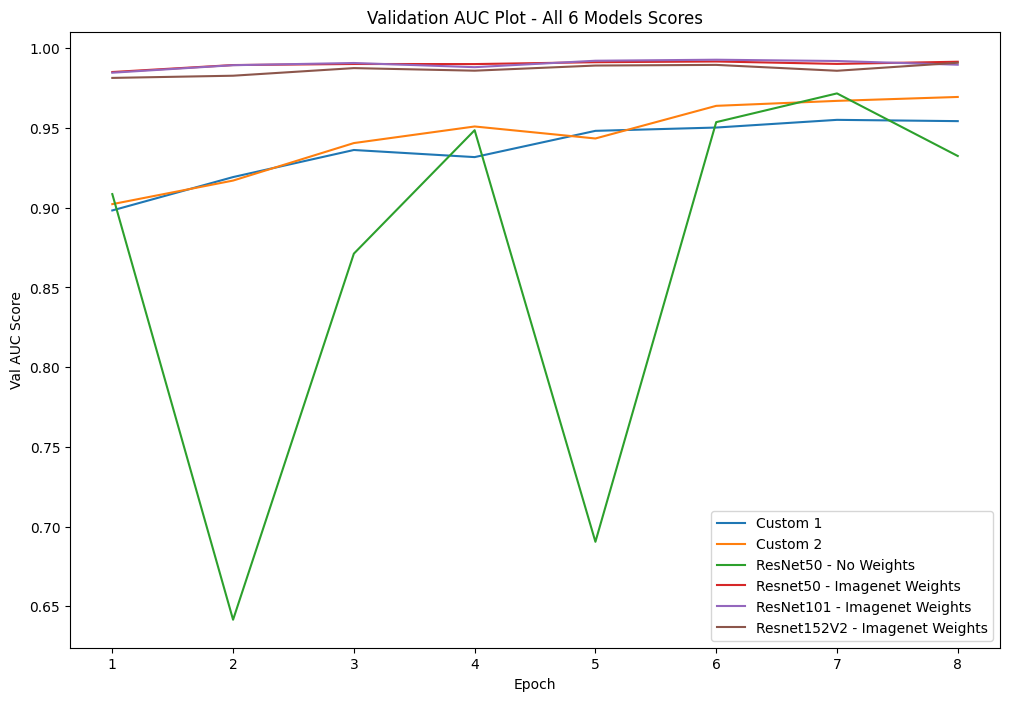

In [21]:
# Plot results for 6 models
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.ylabel("Val AUC Score")
plt.title("Validation AUC Plot - All 6 Models Scores")
epochs_list = list(range(1, len(history_val_auc_list[0])+1))
labels_list = ['Custom 1', 
               'Custom 2', 
               'ResNet50 - No Weights', 
               'Resnet50 - Imagenet Weights', 
               'ResNet101 - Imagenet Weights', 
               'Resnet152V2 - Imagenet Weights']
for i in range(len(history_val_auc_list)):
    plt.plot(epochs_list, history_val_auc_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

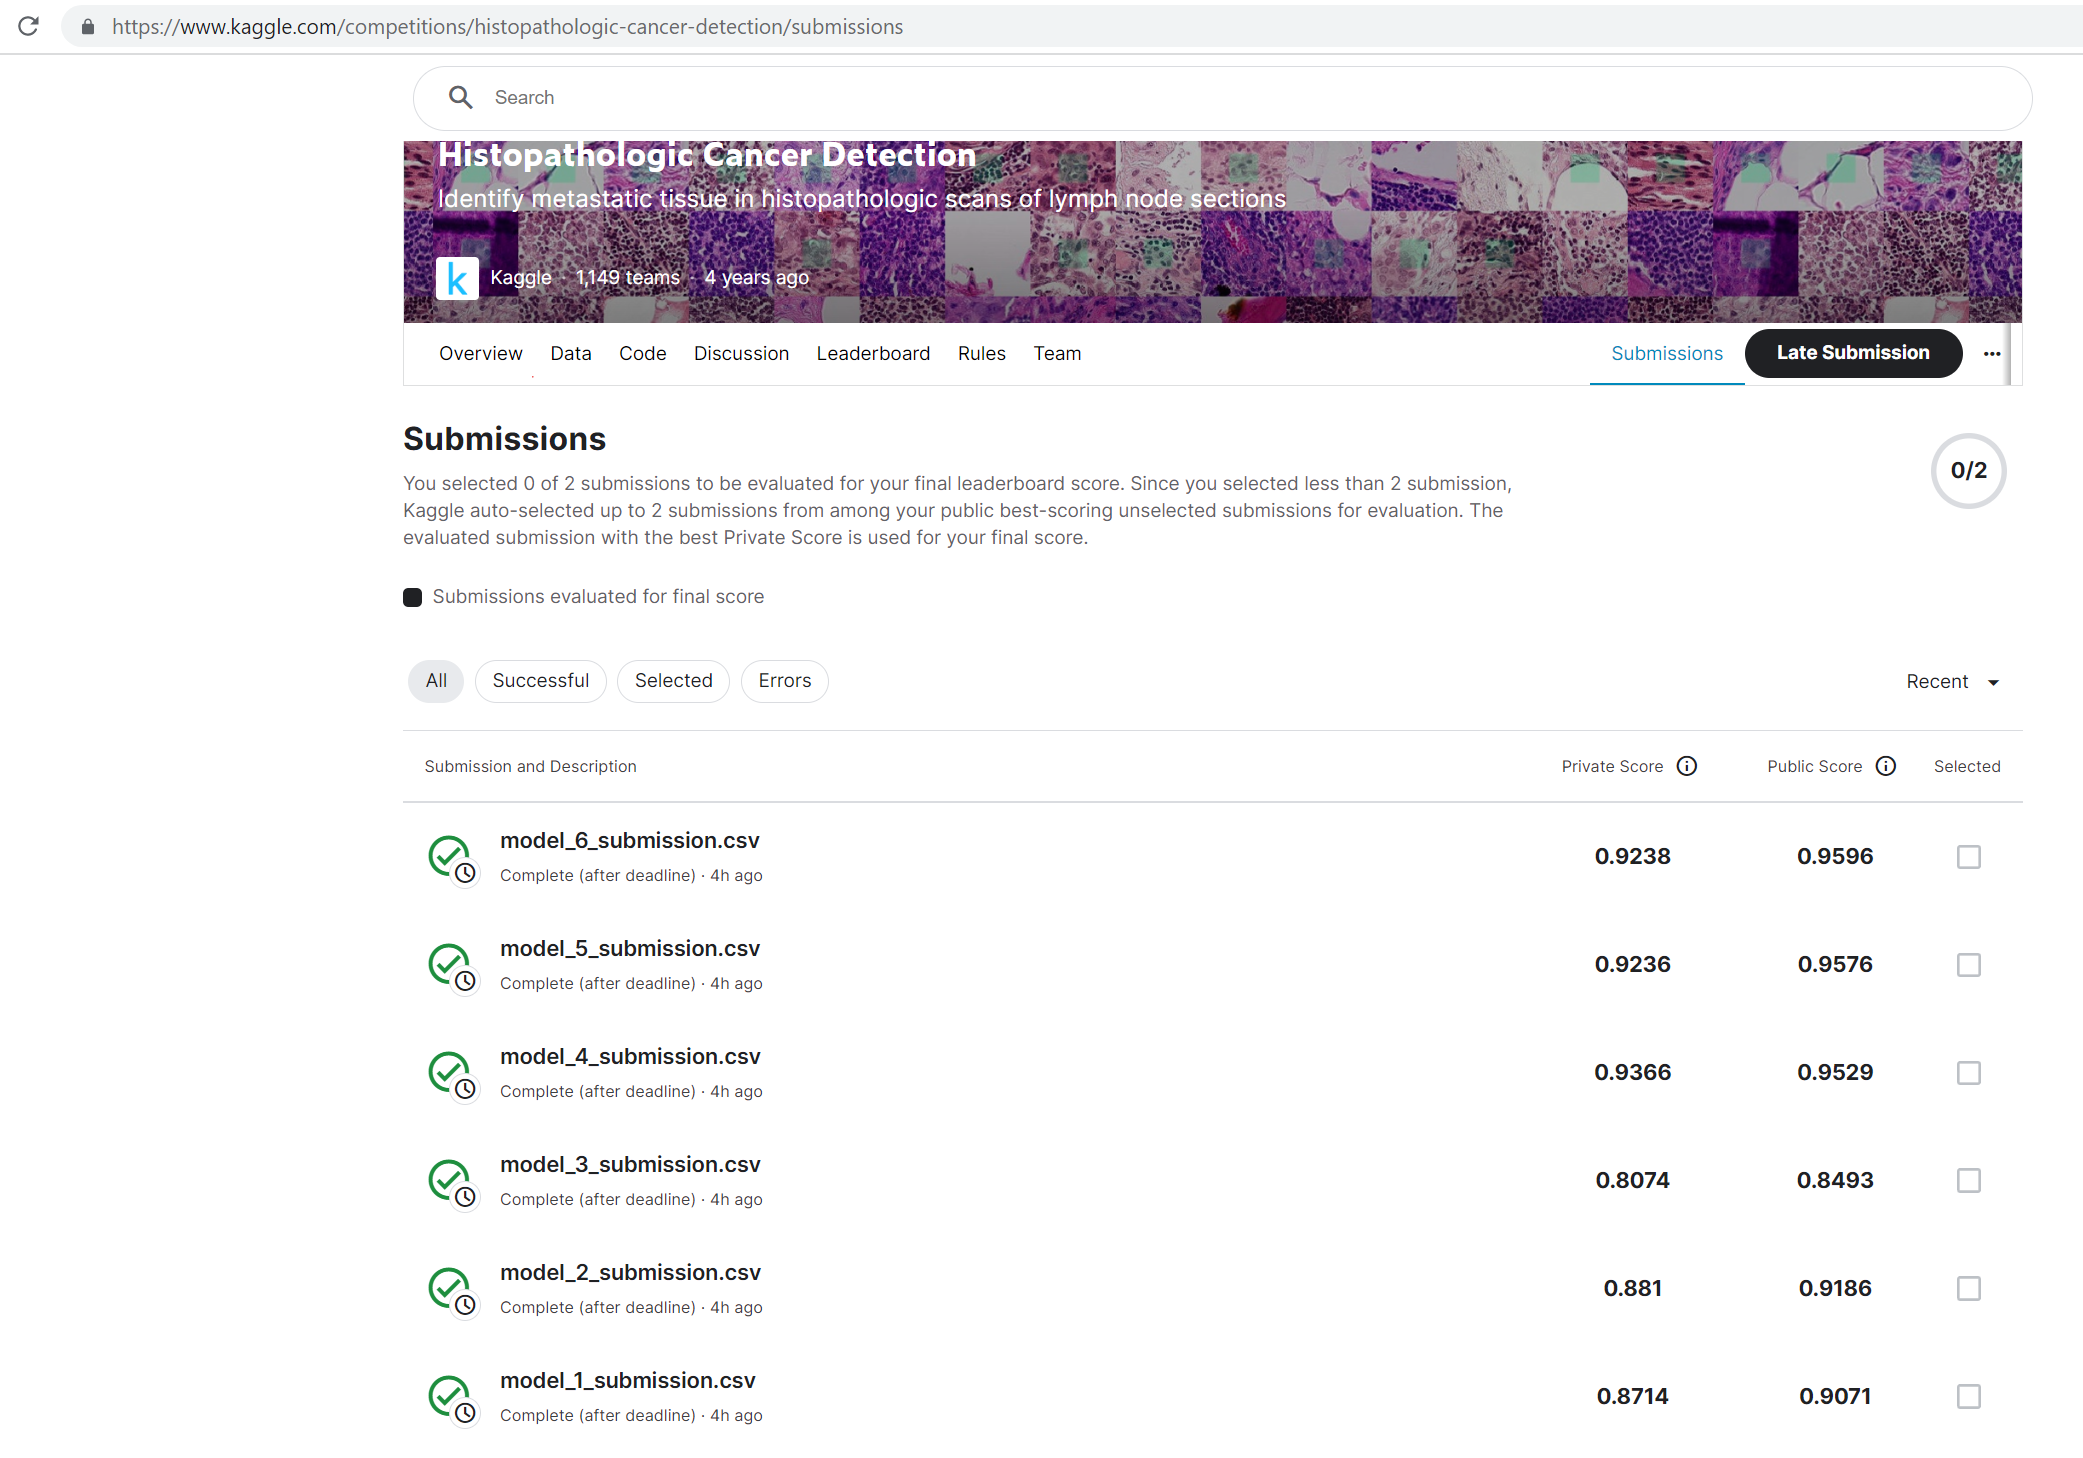

### 5.2 Hyperparameter tuning - Dropout Results

The Dropout is used as a regularization layer preventing the model from overfitting. For the hyperparameter tuning we tested 3 different values for the Dropout: [0.0, 0.25, 0.50].

The plot below shows that for all 3 values of the Dropout a high Validation AUC is achieved of around or little over 99.2%.

It is interresting to observe that for the Dropout value of 0.0 it achieves its highest Validation AUC score quitte quickly. Already after 5 epochs it has its maximum value and then starts to drop showings signs of possible overfitting. The Dropout value of 0.25 achieves it highest Validation AUC in the last epoch (the 8th). It shows the most stable pattern for the Validation AUC score and the plot suggests that training for more epochs would likely increase the Validation AUC score even more.

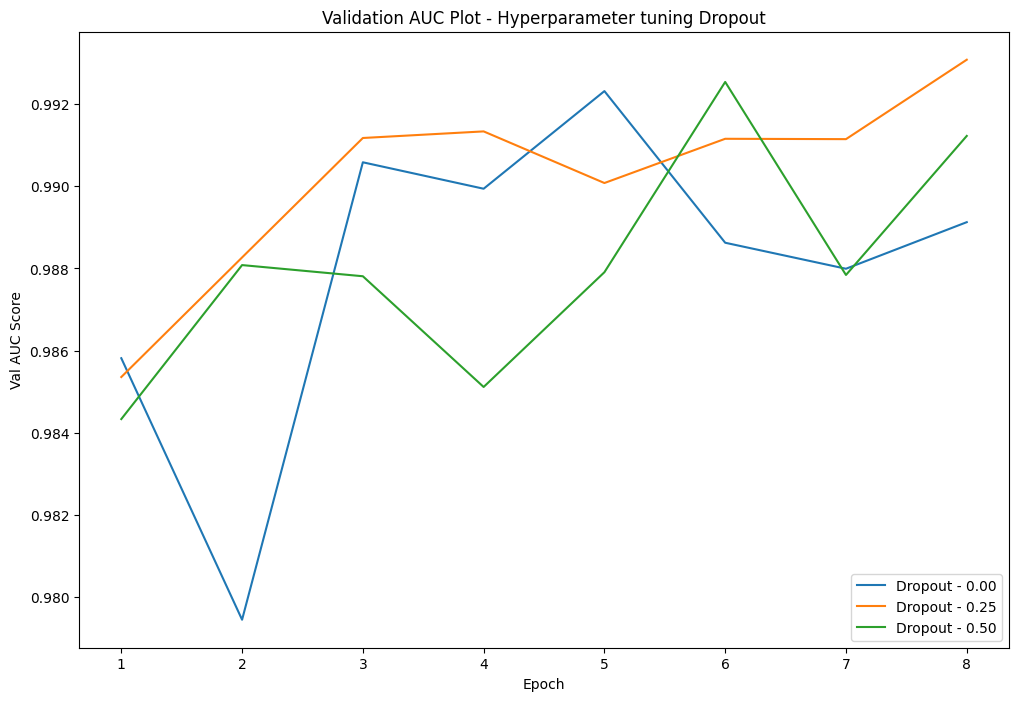

In [22]:
# Plot results for Dropout Hyperparameter tuning
epochs_list = list(range(1, len(history_val_auc_dropout_list[0])+1))
labels_list = ['Dropout - 0.00', 
               'Dropout - 0.25', 
               'Dropout - 0.50']
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.xticks(epochs_list)
plt.ylabel("Val AUC Score")
plt.title("Validation AUC Plot - Hyperparameter tuning Dropout")

for i in range(len(history_val_auc_dropout_list)):
    plt.plot(epochs_list, history_val_auc_dropout_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

### 5.3 Hyperparameter tuning - Learning Rate Results

The hyperparameter tuning of the learning rate shows us that the smallest learning rate achieves the highest performance when looking at the plot of the Validation AUC for all 3 different learning rates.

The learning rate of 0.001 still gives a high performance but scores a little lower than the smallest learning rate. It is interresting to mention that the learning rate of 0.001 is actually the default learning rate for the Adam optimizer as implemented within Tensorflow.

When we increase the learning rate even further to 0.01 the validation AUC score achieved is severely lowered. The model is likely overfitting on the training data and fails to achieve a good performance on the validation dataset. It is also noteworthy that the smallest learning rate of 0.0001 is the only one that has a stable Validation AUC score.

Based on these results it would be interresting to continue to explore learning rates with hyperparameter tuning that are smaller than 0.0001.

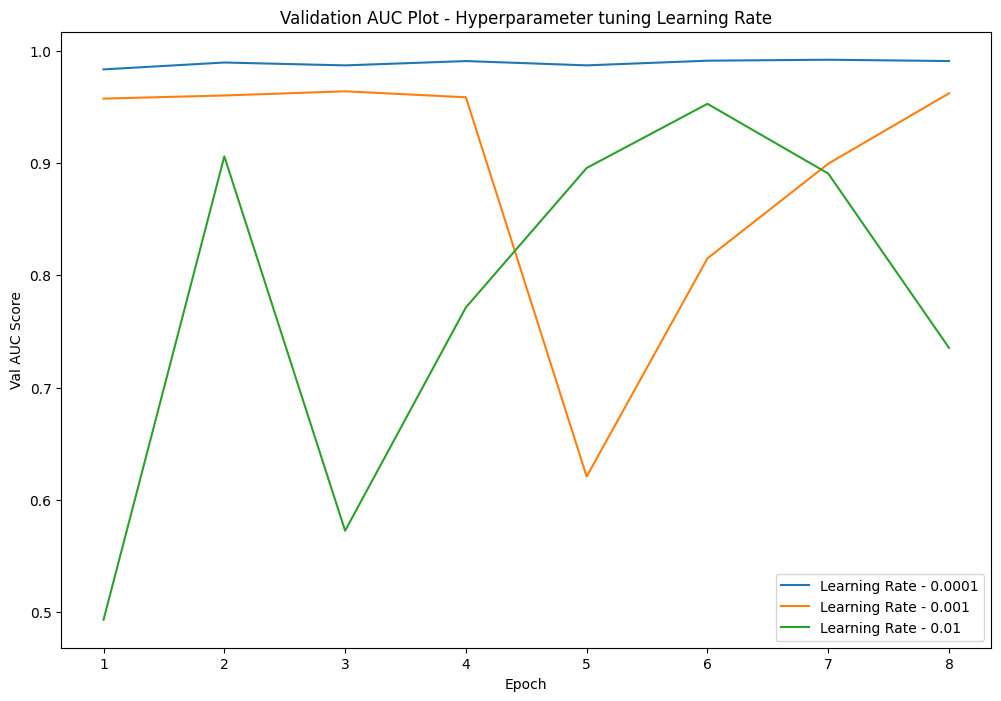

In [23]:
# Plot results for Learning Rate Hyperparameter tuning
epochs_list = list(range(1, len(history_val_auc_lr_list[0])+1))
labels_list = ['Learning Rate - 0.0001', 
               'Learning Rate - 0.001', 
               'Learning Rate - 0.01']
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.xticks(epochs_list)
plt.ylabel("Val AUC Score")
plt.title("Validation AUC Plot - Hyperparameter tuning Learning Rate")

for i in range(len(history_val_auc_lr_list)):
    plt.plot(epochs_list, history_val_auc_lr_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

## 6. Conclusion

We've looked at 6 different models, trained and validated them. Also we performed 2 different hyperparameter tuning experiments which gave us insight into the performance achieved when varying the Dropout or Learning Rate.

Based on the information looked at in the Results and Analysis section there are 2 points that are really worth mentioning.

First of all. While not achieving the top performance achieved by the various ResNet models the 2 custom CNN model architectures are getting fairly close when looking at the Validation AUC score. If we look at the Kaggle submission scores the custom CNN models are only 5% behind the ResNet models. They are trained from scratch and are created with a simple and basic CNN architecture. It is very likely that with some simple modifications the custom CNN architectures could be improved even further.

Second point that is worth mentioning. For the 3 ResNet models with increasing amount of layers trained with transfer learning we observed the validation AUC score remained roughly the same between 99.0 - 99.3%. A larger model size does not necessarily achieve a higher performance. The performance achieved based on the Kaggle competition submission scores increases on the Public LB when the amount of layers increases. The top scoring model on the Private LB is however the ResNet50. This could mean that the data distribution on the Private LB is different from the training dataset and the Public LB. It seems in this case that the ResNet50 model is able to better generalize than the ResNet101 and ResNet152 models.

Further options that could be explored to improve the performance even more in the future would be the following:
1. Use Cross Validation for training and create ensembles of the models. Average the predicted probabilities.
2. Further hyperparameter tuning. There are a lot more parameters that can be explored.
3. Learning Rate scheduling.
4. Try augmentation techniques like cropping, MixUp, CutMix or RandAugment
5. Explore the use of Vision Transformer models like ViT, BEIT or Swin Transformers.
6. Explore the further modifications of the custom CNN architectures.